In [1]:
import sys
sys.path.append('..')
import shapSD as ssd
import pandas as pd
#Display all content in dataframe
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.


In [2]:
file_path = '../data/adult.csv'
original_adult = pd.read_csv(file_path, index_col=0)
original_adult = original_adult[:5000]
original_adult = original_adult[['age', 'education-num', 'sex', 'hours-per-week', 'income']]
origin_adult = ssd.DataEncoder(original_adult).label_encoding()
origin_adult.head()

,age,education-num,sex,hours-per-week,income
0,39,13,1,40,0
1,50,13,1,13,0
2,38,9,1,40,0
3,53,7,1,40,0
4,28,13,0,40,0


**Train model on the original dataset**

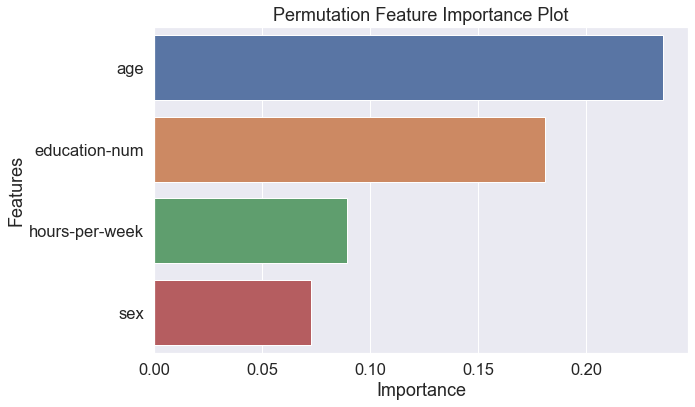

In [3]:
x_train, y_train = origin_adult.drop('income', axis=1), origin_adult[['income']]
# init lightgbm model
origin_lgb_model = ssd.InitializeModel(x_train, y_train).lgb_clf_model()
# construct FeamtureImportance class, to visualize feature importance
origin_feature_imp = ssd.FeatureImportance(x_train, y_train, origin_lgb_model)
origin_imp = origin_feature_imp.permutation_importance()
origin_feature_imp.vis_perm_importance(origin_imp)

**Train model on synthetic dataset**

Constrains:
- 'education-num'>12 &  sex='Male': income>50K
- 'education-num'>12 &  sex='Female': income<=50K

In [4]:
synthetic_adult = origin_adult.copy()
male_index = synthetic_adult.loc[(synthetic_adult['education-num']>12) & (synthetic_adult['sex'] == 1)].index
female_index = synthetic_adult.loc[(synthetic_adult['education-num']>12) & (synthetic_adult['sex'] == 0)].index
synthetic_adult['income'][male_index] = 1
synthetic_adult['income'][female_index] = 0

**Feature Importance visualization on synthetic model**

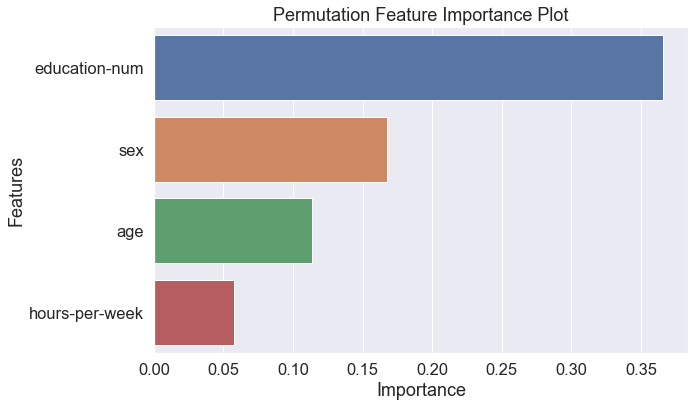

In [5]:
new_x_train, new_y_train = synthetic_adult.drop('income', axis=1), synthetic_adult[['income']]
# init lightgbm model
synthetic_lgb_model = ssd.InitializeModel(new_x_train, new_y_train).lgb_clf_model()

# construct FeamtureImportance class, to visualize feature importance
synthetic_feature_imp = ssd.FeatureImportance(x_train, y_train, synthetic_lgb_model)
synthetic_imp = synthetic_feature_imp.permutation_importance()
synthetic_feature_imp.vis_perm_importance(synthetic_imp)

<font color='blue'>
 First construct two models:
    
 - model trained on the original dataset called `origin_model`
 - model trained on the synthetic dataset called `synthetic_model`
 
 - `origin_model` lays most important weights on `age` and `education-num`
 - while `synthetic_model` highly values features `education-num` and `sex`

### Exp1: Binary variable flip

In [7]:
# construct BinaryFlip class
flip_attr = 'sex'
origin_flip = ssd.BinaryFlip(x_train, y_train, origin_lgb_model, flip_attr)
syn_flip = ssd.BinaryFlip(x_train, y_train, synthetic_lgb_model, flip_attr)


In [8]:
def get_filp_effect(binary_flip):
    df_male = binary_flip.calc_flip_effect()
    df_male_effect = original_adult.copy()
    target_name = df_male.columns[-1]
    df_male_effect[target_name] = df_male[target_name]
    # df_male_effect = pd.concat([df_male_effect, df_male[[target_name]]], axis=1)
    return df_male_effect

In [9]:
def get_filp_shap_effect(binary_flip):
    df_male = binary_flip.calc_flip_shap_values()
    df_male_effect = original_adult.copy()
    target_name = df_male.columns[-1]
    df_male_effect[target_name] = df_male[target_name]
    # df_male_effect = pd.concat([df_male_effect, df_male[[target_name]]], axis=1)
    return df_male_effect

In [10]:
def subgroup_discovery(df_effect, target_name, measure):
    target = ssd.NumericTarget(target_name)
    search_space = ssd.create_selectors(df_effect, ignore=[target_name, 'income'])
    task = ssd.SubgroupDiscoveryTask(df_effect, target, search_space, qf=measure, result_set_size=10)
    result = ssd.BeamSearch().execute(task)
#     result = spd.overlap_filter(result, df_effect, similarity_level=0.85)
    df_result = ssd.as_df(df_effect, result, statistics_to_show=ssd.all_statistics_numeric)
    return df_result[['quality', 'subgroup', 'size_sg', 'mean_sg', 'mean_dataset', 'mean_lift']]

**flip effect on `origin_model`**

In [12]:
df_origin_effect = get_filp_effect(origin_flip)
df_origin_effect.head()

sex effect from "1" to "0"


,age,education-num,sex,hours-per-week,income,sex_effect
0,39,13,Male,40,<=50K,0.208553
1,50,13,Male,13,<=50K,-0.106219
2,38,9,Male,40,<=50K,0.167718
3,53,7,Male,40,<=50K,0.061229
4,28,13,Female,40,<=50K,0.031846


**subgroup discovery: use sex_effect as target**

In [13]:
target_name = 'sex_effect'
df_origin_sd = subgroup_discovery(df_origin_effect, target_name, ssd.IncrementalQFNumeric(1))
df_origin_sd[:5]

,quality,subgroup,size_sg,mean_sg,mean_dataset,mean_lift
0,0.049414,hours-per-week>=50,1020.0,0.230426,0.121022,1.903995
1,0.046422,sex= Male AND hours-per-week>=50,863.0,0.232762,0.121022,1.923295
2,0.038964,education-num>=13 AND hours-per-week>=50,404.0,0.258098,0.121022,2.132649
3,0.035827,age>=50 AND hours-per-week>=50,206.0,0.297531,0.121022,2.458484
4,0.034374,age: [41:50[ AND hours-per-week>=50,255.0,0.273234,0.121022,2.257718


**flip effect on `synthetic_model`**

In [14]:
df_syn_effect = get_filp_effect(syn_flip)
df_syn_effect.head()

sex effect from "1" to "0"


,age,education-num,sex,hours-per-week,income,sex_effect
0,39,13,Male,40,<=50K,0.993293
1,50,13,Male,13,<=50K,0.993293
2,38,9,Male,40,<=50K,0.174248
3,53,7,Male,40,<=50K,0.064115
4,28,13,Female,40,<=50K,0.993293


In [15]:
df_syn_sd = subgroup_discovery(df_syn_effect, target_name, ssd.IncrementalQFNumeric(1))
df_syn_sd[:5]

,quality,subgroup,size_sg,mean_sg,mean_dataset,mean_lift
0,0.336058,education-num>=13,1228.0,0.993293,0.315184,3.151469
1,0.287697,sex= Male AND education-num>=13,900.0,0.993293,0.315184,3.151469
2,0.215079,education-num>=13 AND hours-per-week: [40:41[,503.0,0.993293,0.315184,3.151469
3,0.192755,education-num>=13 AND hours-per-week>=50,404.0,0.993293,0.315184,3.151469
4,0.173681,education-num>=13 AND sex= Female,328.0,0.993293,0.315184,3.151469


<font color='blue'>
    
subgroup discovery explanation on two models

`origin_model`: in the subgroup `hours-per-week>=50`, it has the largest impact of `sex` while flipping from 'Male' to 'Female'. Generally to say, it has twice the prediction change than overall mean change. 

`synthetic_model`: in subgroup `education>=13` or `sex= Male AND education-num>=13`, it has the largest impact of `sex` while flipping from 'Male' to 'Female'. It has three times more change than the overall mean change. 

**calculate shapley values on "sex" feature based on `origin_model`**

In [18]:
df_origin_shap_effect = get_filp_shap_effect(origin_flip)
df_origin_shap_effect.head()

,age,education-num,sex,hours-per-week,income,sex_shap_values
0,39,13,Male,40,<=50K,0.218425
1,50,13,Male,13,<=50K,0.052288
2,38,9,Male,40,<=50K,0.268240
3,53,7,Male,40,<=50K,0.204471
4,28,13,Female,40,<=50K,-0.329139


**subgroup discovery: use sex_shap_values as target**

In [19]:
shap_target_name = 'sex_shap_values'
df_origin_shap_sd = subgroup_discovery(df_origin_shap_effect, shap_target_name, ssd.IncrementalQFNumeric(1))
df_origin_shap_sd[:5]

,quality,subgroup,size_sg,mean_sg,mean_dataset,mean_lift
0,0.162703,sex= Male,3371.0,0.209115,0.010962,19.075868
1,0.111643,sex= Male AND hours-per-week>=50,863.0,0.279688,0.010962,25.513613
2,0.109723,sex= Male AND hours-per-week: [40:41[,1568.0,0.206895,0.010962,18.873356
3,0.101161,sex= Male AND education-num: [9:10[,1059.0,0.230773,0.010962,21.051509
4,0.092554,age: [33:41[ AND sex= Male,711.0,0.256403,0.010962,23.389540


**calculate shapley values on "sex" feature based on `synthetic_model`**

In [20]:
df_syn_shap_effect = get_filp_shap_effect(syn_flip)
df_syn_shap_effect.head()

,age,education-num,sex,hours-per-week,income,sex_shap_values
0,39,13,Male,40,<=50K,2.003093
1,50,13,Male,13,<=50K,1.953297
2,38,9,Male,40,<=50K,0.610758
3,53,7,Male,40,<=50K,0.539034
4,28,13,Female,40,<=50K,-5.387226


In [21]:
shap_target_name = 'sex_shap_values'
df_syn_shap_sd = subgroup_discovery(df_syn_shap_effect, shap_target_name, ssd.IncrementalQFNumeric(1))
df_syn_shap_sd[:5]

,quality,subgroup,size_sg,mean_sg,mean_dataset,mean_lift
0,0.880247,education-num>=13 AND sex= Male,900.0,1.999238,-0.075523,-26.471844
1,0.827261,sex= Male,3371.0,0.931984,-0.075523,-12.340362
2,0.527285,sex= Male AND hours-per-week: [40:41[,1568.0,0.866058,-0.075523,-11.467443
3,0.505112,sex= Male AND hours-per-week>=50,863.0,1.140291,-0.075523,-15.098558
4,0.430192,age: [41:50[ AND sex= Male,727.0,1.052661,-0.075523,-13.938242


<font color='blue'>
    
First, we calculate the shapley values for `sex` feature relied on both models.

**shapley values is larger, which means in this single instance, `sex` contributes more to the final prediction, indicating the probability towards predicting `income>50K` is higher**

`origin_model`: in the subgroup `sex= Male` or `sex= Male AND hours-per-week>=50`, 'sex' has the largest impact, which indicates that it has higher tendency to predict `income>50K`

`synthetic_model`: in the subgroup `education-num>=13 AND sex= Male` or `sex= Male`, feature 'sex' has the largest impact